# Data z reálné jízdy (RSX-UM7)
> Zkoumání pro korelaci s realitou

### 📙 Importy

In [1]:
import pandas as pd
import tconsumption
from umparse import um_csv_parser, make_geojson
import matplotlib.pyplot as plt
import ruptures as rpt
import importlib
from csv2geojson import prep
import json
from fastdtw import fastdtw
from dbrail2geojson import get_rail

pd.options.mode.chained_assignment = None

### ⬇️ Načtení souboru se surovými daty

In [2]:
df = um_csv_parser("../testing-data/um7/um7capture_2023-09-29_06-26-06.csv") # Korekce pro začátek jízdy
df["accel_proc_y"] *= -1 # Korekce pro jízdní směr

# geojson = make_geojson(df["gps_latitude"], df["gps_longitude"])
# with open("/tmp/test.geojson", "w") as f:
#     f.write(geojson)

Index(['time', 'packet_type', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_course', 'gps_speed', 'gps_time', 'gyro_proc_x', 'gyro_proc_y',
       'gyro_proc_z', 'gyro_proc_time', 'accel_proc_x', 'accel_proc_y',
       'accel_proc_z', 'accel_proc_time', 'mag_proc_x', 'mag_proc_y',
       'mag_proc_z', 'mag_proc_time', 'velocity_north', 'velocity_east',
       'velocity_up', 'velocity_time'],
      dtype='object')


### 🔎 Náhled na akceleraci a rychlost v celém souboru

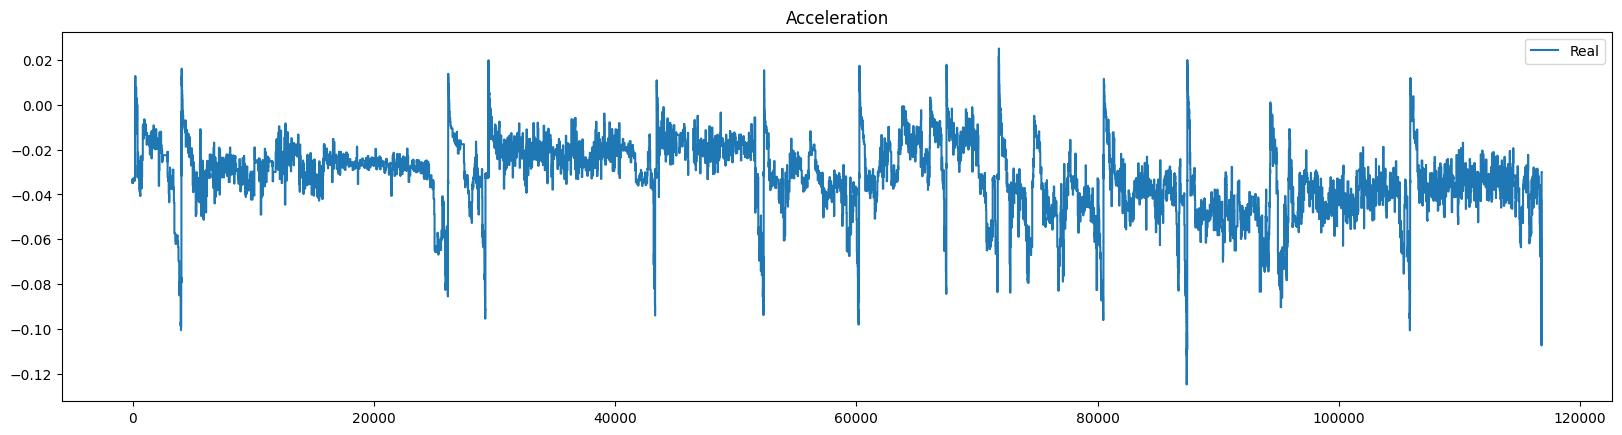

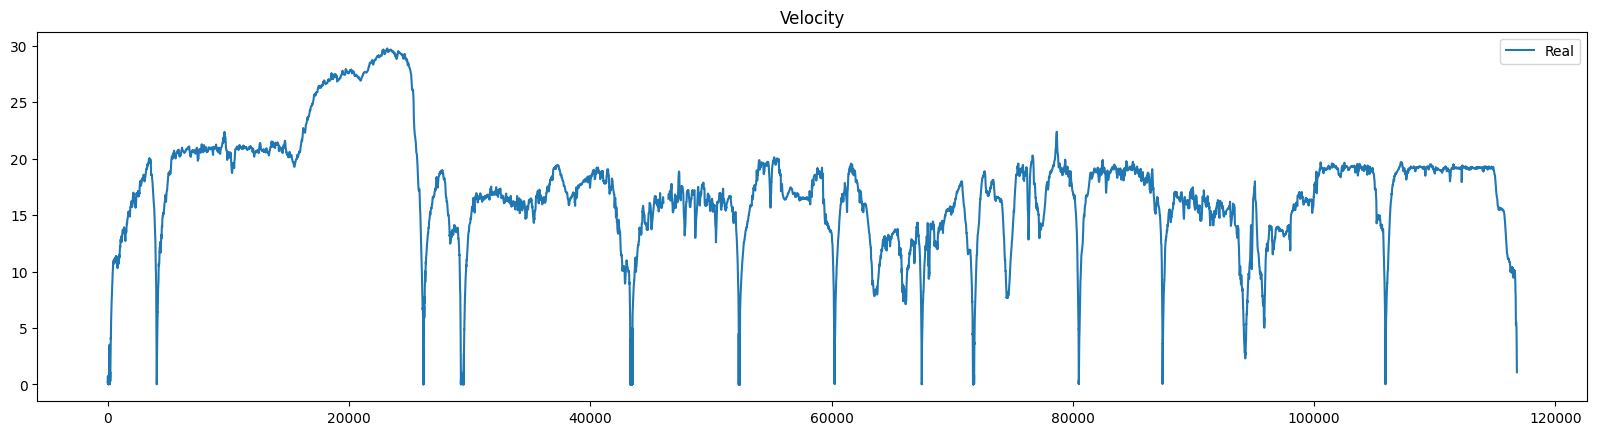

In [3]:
plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["accel_proc_y"])
plt.title("Acceleration")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["gps_speed"])
plt.title("Velocity")
plt.legend(["Real"], loc ="upper right")
plt.show()

# plt.figure().set_figwidth(20)
# plt.plot(df["cumulative_distance_m"], df["gps_speed_raw"])
# plt.title("Velocity")
# plt.legend(["Real"], loc ="upper right")
# plt.show()

# plt.figure().set_figwidth(20)
# plt.plot(df["cumulative_distance_m"], df["gps_speed_delta"])
# plt.title("Velocity delta")
# plt.legend(["Real"], loc ="upper right")
# plt.show()

### 🛠️ Funkce pro zpracování

In [4]:
def render_plot(title, x, ys, labels, linestyles=None, width=20):
    if linestyles is None:
        linestyles = ["solid"]*len(ys)
    plt.figure().set_figwidth(width)
    for i,y in enumerate(ys):
        plt.plot(x, y, linestyle=linestyles[i])
    plt.title(title)
    if len(labels) > 0:
        plt.legend(labels, loc ="upper right")
    plt.show()

In [5]:
def map_velocity(df_measured, first_offset, velocity_fp):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    first_dist = df_measured["cumulative_distance_m"].iloc[0]
    for tv in track_velocity:
        start_in_m = tv["start"]*1000
        df_measured.loc[first_offset*1000 - (df_measured["cumulative_distance_m"]-first_dist) <= start_in_m, "track_velocity"] = tv["value"]

    df_measured["track_velocity_m_s"] = df_measured["track_velocity"]/3.6

In [6]:
def compare_data(df_measured, geojson_path: str):
    # # Data identification
    # data_name = os.path.basename(geojson_path).split(".")[0]

    # Calculated data
    c = tconsumption.Consumption()
    c.variable_params = {
        'Recuperation coefficient': 0.6998270177197322,
        'Curve A': 226.0739452231682,
        'Curve B': 55.026751900632405,
        'Running a': 0.706437197926143,
        'Running b': 0.01899266921470387,
        'Running c': 0.008283331094691721,
        'Comfortable acceleration': 0.11725031534778388,
        'Elevation smoothing': 100,
        'Curve smoothing': 10
    }
    c.load_from_file(geojson_path)
    c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"])
    print("unique velocities in km/h", set([x*3.6 for x in df_measured["track_velocity_m_s"]]))

    # Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
    c.params["power_limit"] = 480*1000
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 31490 + 33000

    # Running the simulation
    c.run()

    # Plotting
    render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    render_plot(
        "Velocity",
        c.series["dist_values"],
        [c.series["velocity_values"], df_measured["gps_speed"], c.max_velocities_in_mps],
        ["Simulation", "Real", "Limit"],
        ["solid", "solid", "dashed"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [df_measured["accel_proc_y"]],
        ["Real"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [c.series["acceleration_values"]],
        ["Simulation"]
    )

    dtw = fastdtw(c.series["velocity_values"], df_measured["gps_speed"])[0]
    print("DTW:", dtw)

    # render_plot(
    #     "Acceleration",
    #     c.series["dist_values"][:100],
    #     [c.series["acceleration_values"][:100]],
    #     ["Simulation (slice)"]
    # )

### 🛤️ Zpracované úseky

#### Opava západ ➡️ Krnov-Cvilín

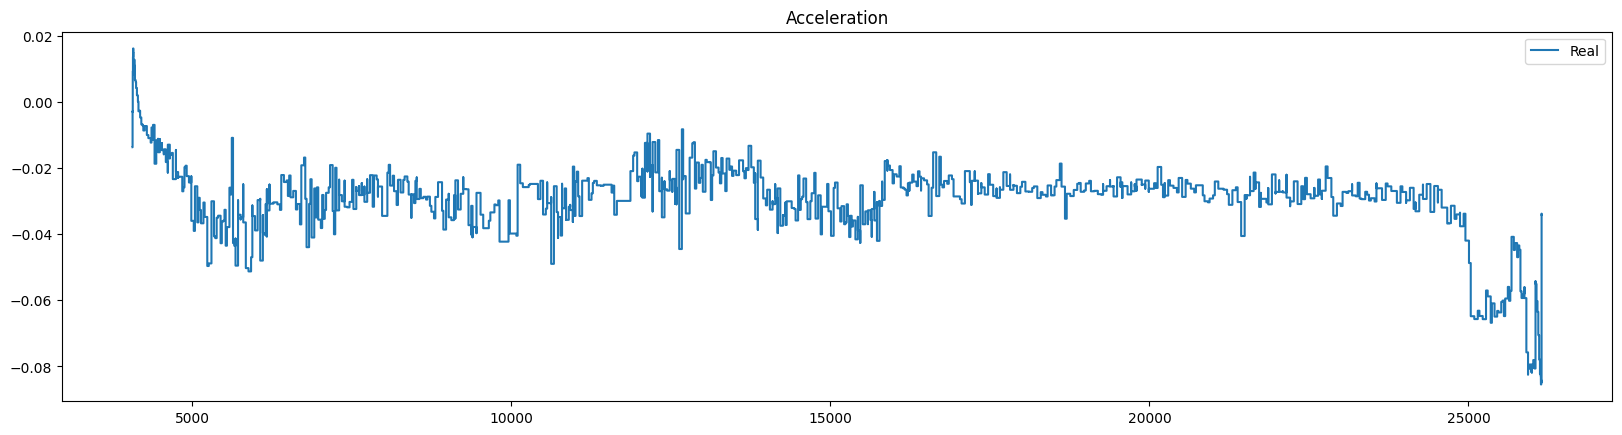

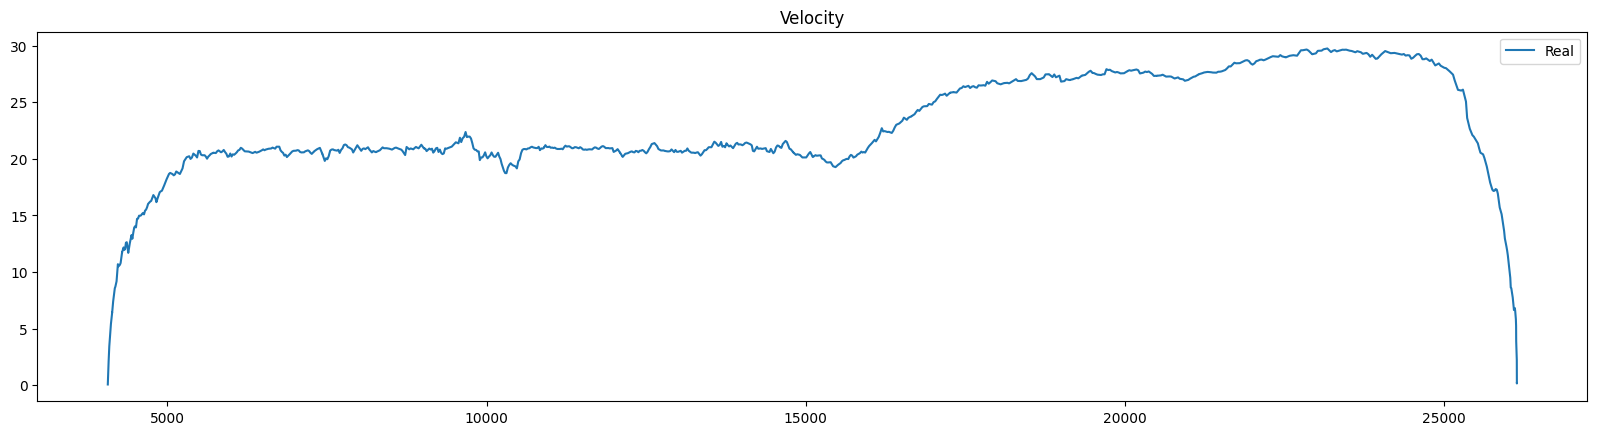

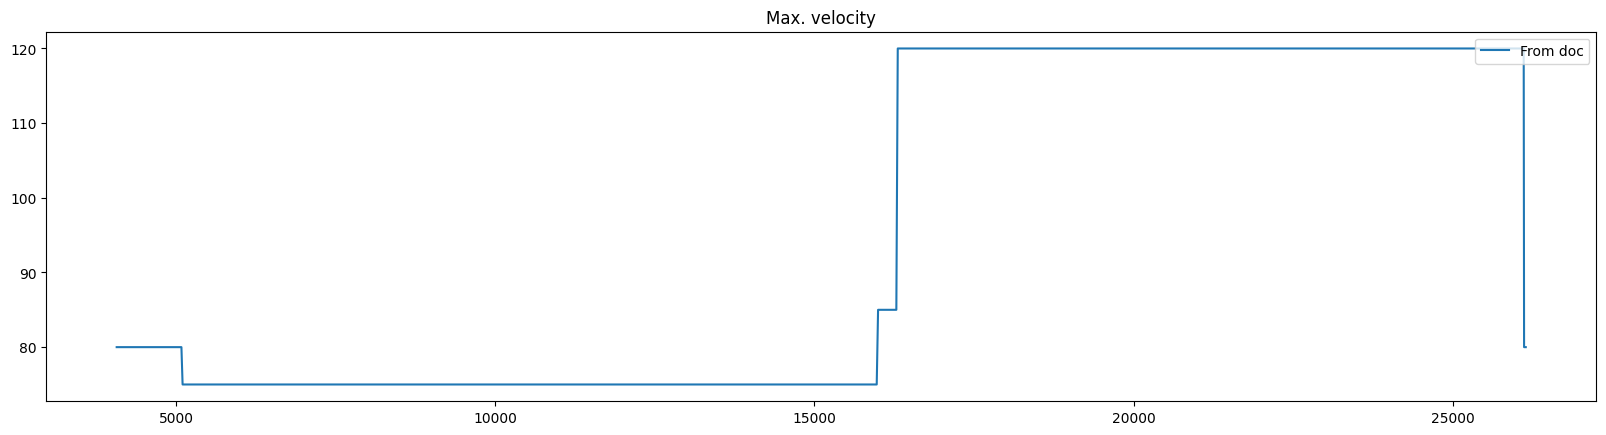

In [7]:
df_slice = df.loc[1080:3530] # Rozsah bodů mezi stanicemi

map_velocity(df_slice, 112.329, "../testing-data/velocity-data/310-pj.json")

# Plots
render_plot("Acceleration", df_slice["cumulative_distance_m"], [df_slice["accel_proc_y"]], ["Real"])
render_plot("Velocity", df_slice["cumulative_distance_m"], [df_slice["gps_speed"]], ["Real"])
render_plot("Max. velocity", df_slice["cumulative_distance_m"], [df_slice["track_velocity"]], ["From doc"])

In [8]:
prep({
    # "input": "NOT NEEDED",
    "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
    "dbtable": "train_testing_data"
}, df=df_slice)

ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such fi

unique velocities in km/h {80.0, 75.0, 120.00000000000001, 85.0}


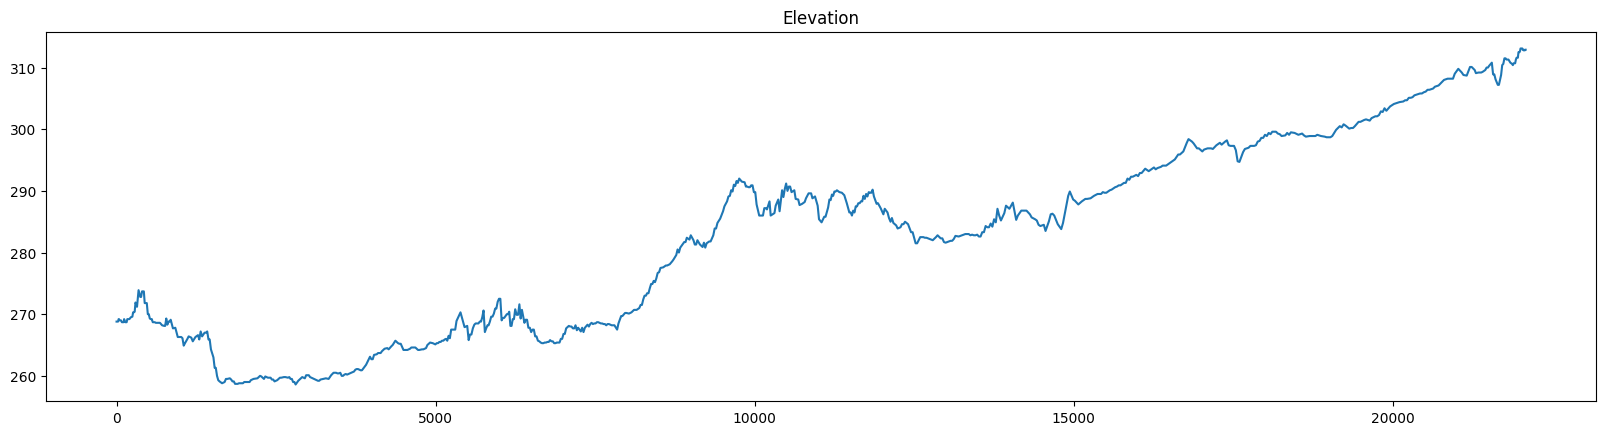

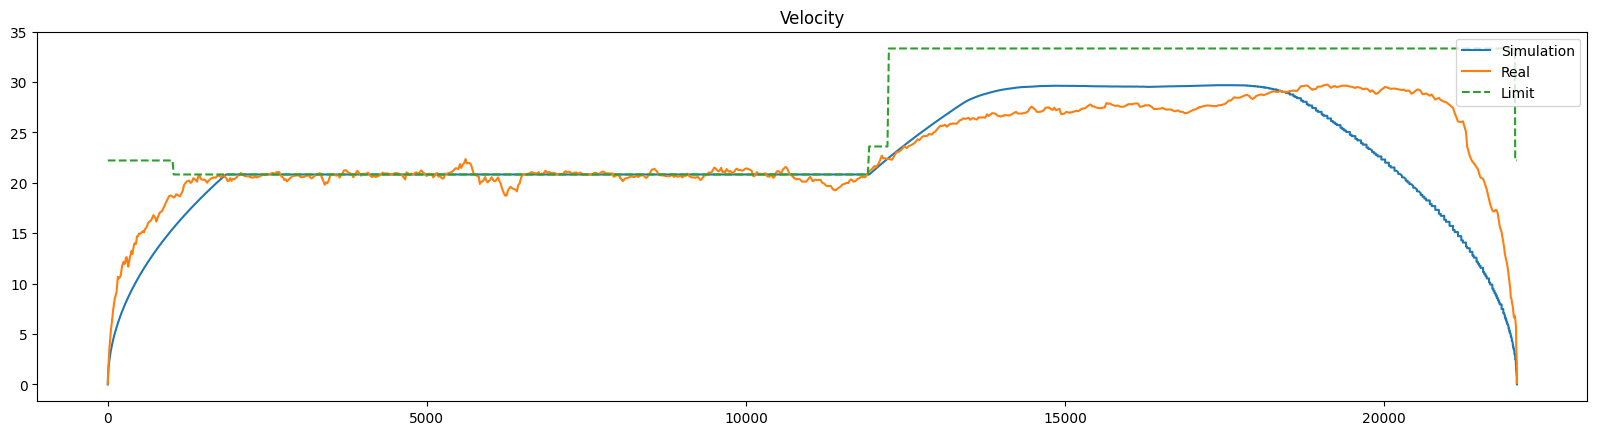

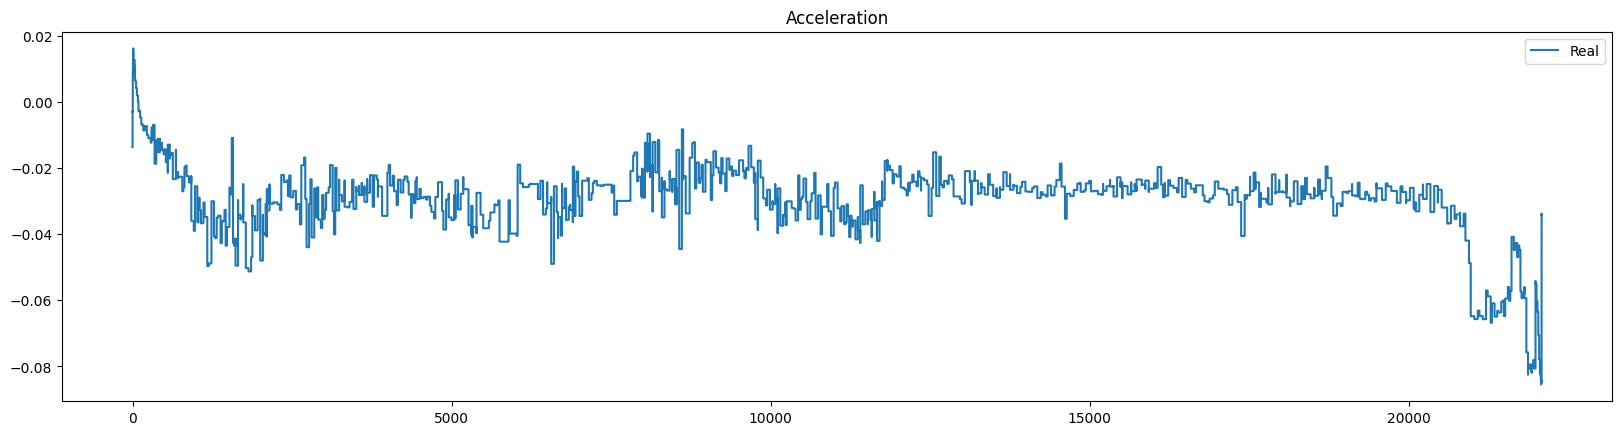

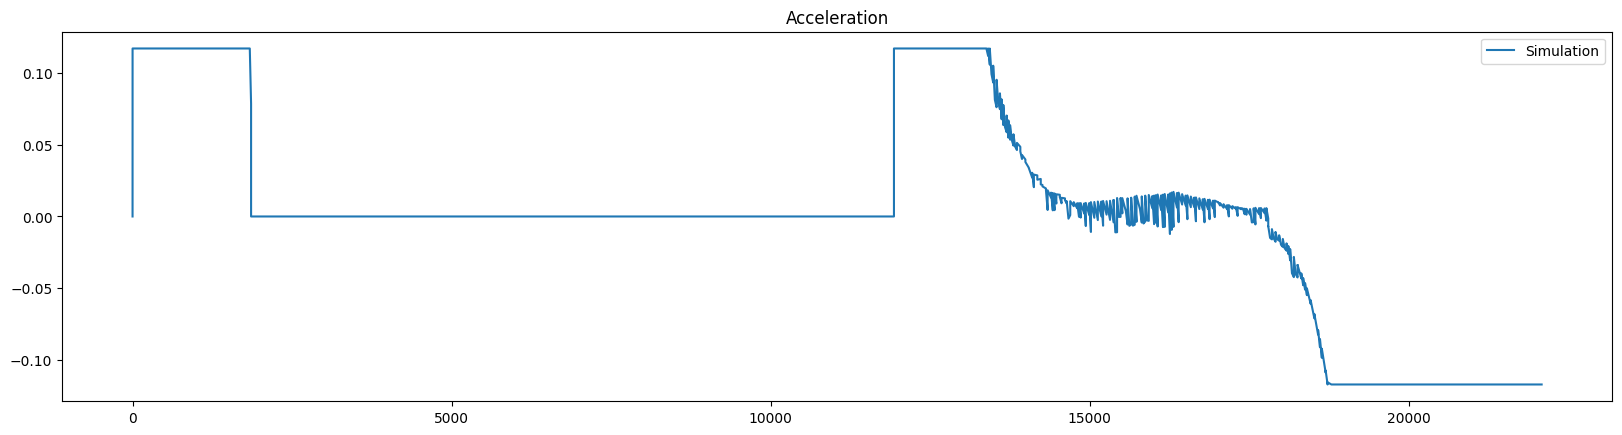

DTW: 611.5773396684032


In [9]:
importlib.reload(tconsumption)

compare_data(
    df_slice,
    "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson"
)

#### Krnov-Cvilín ➡️ Krnov

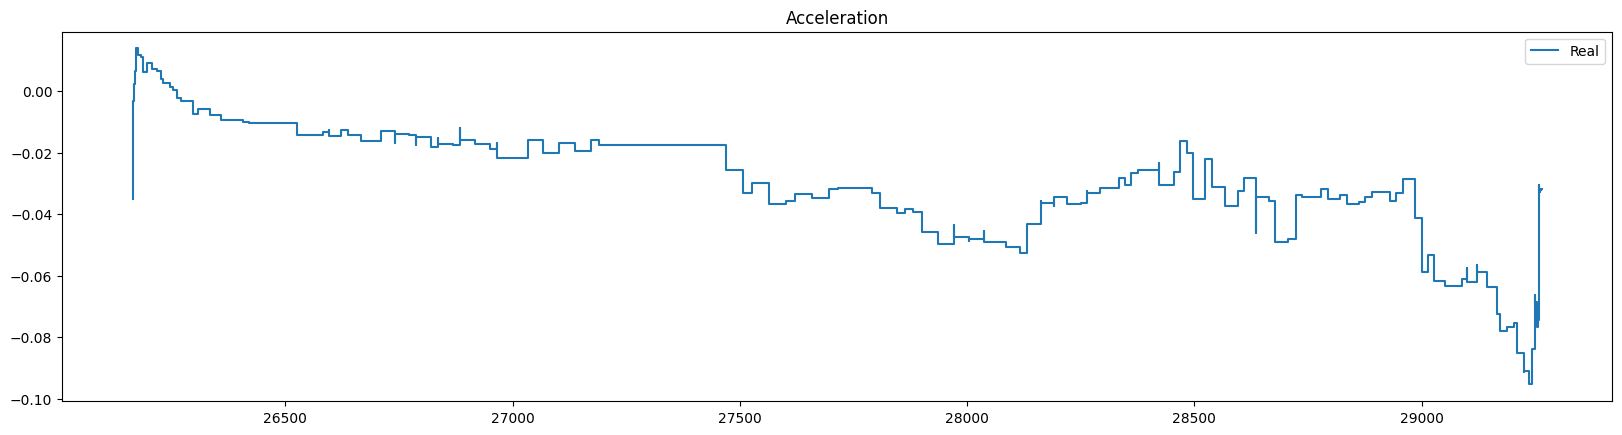

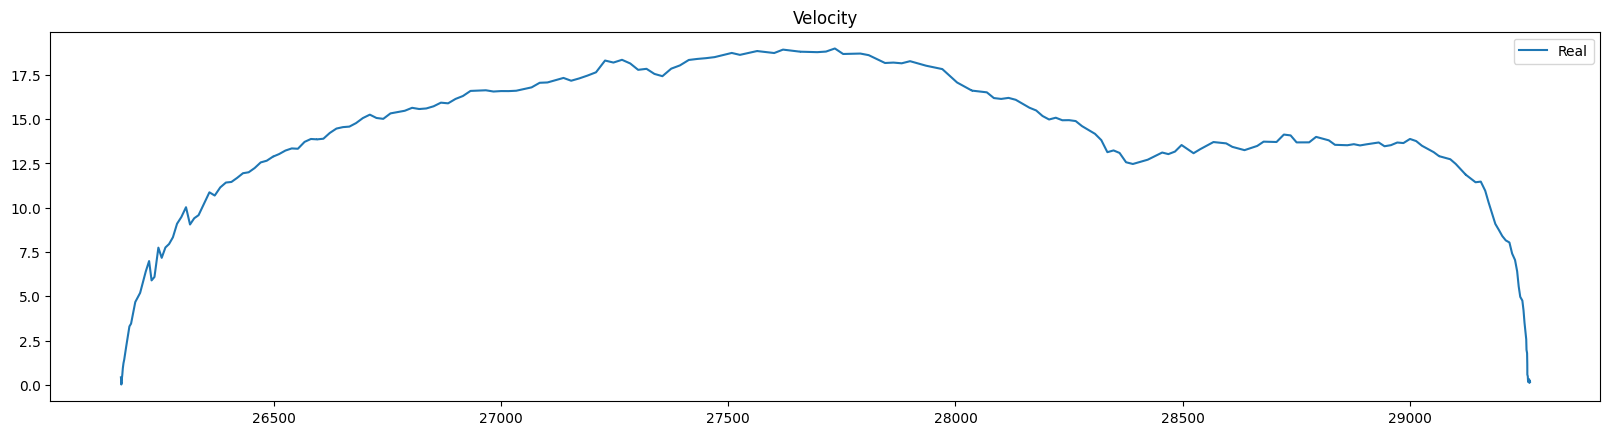

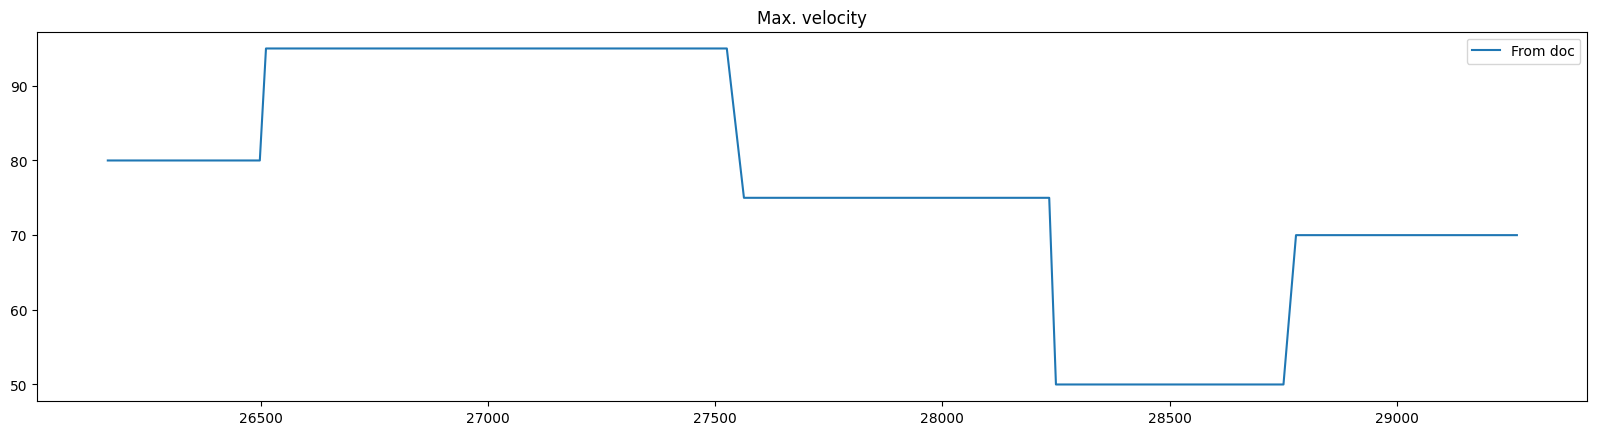

In [10]:
df_slice = df.loc[3680:4280] # Rozsah bodů mezi stanicemi

map_velocity(df_slice, 90.213, "../testing-data/velocity-data/310-pj.json")

render_plot("Acceleration", df_slice["cumulative_distance_m"], [df_slice["accel_proc_y"]], ["Real"])
render_plot("Velocity", df_slice["cumulative_distance_m"], [df_slice["gps_speed"]], ["Real"])
render_plot("Max. velocity", df_slice["cumulative_distance_m"], [df_slice["track_velocity"]], ["From doc"])

In [11]:
prep({
    # "input": "NOT NEEDED",
    "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
    "dbtable": "train_testing_data"
}, df=df_slice)

ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such fi

unique velocities in km/h {70.0, 75.0, 80.0, 50.0, 95.0}


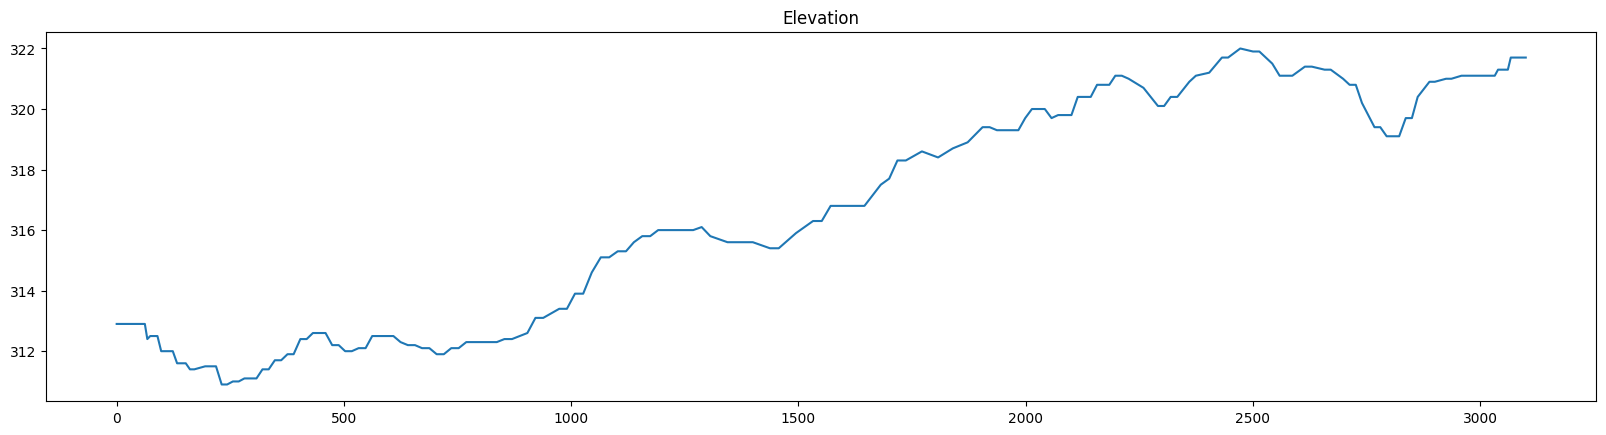

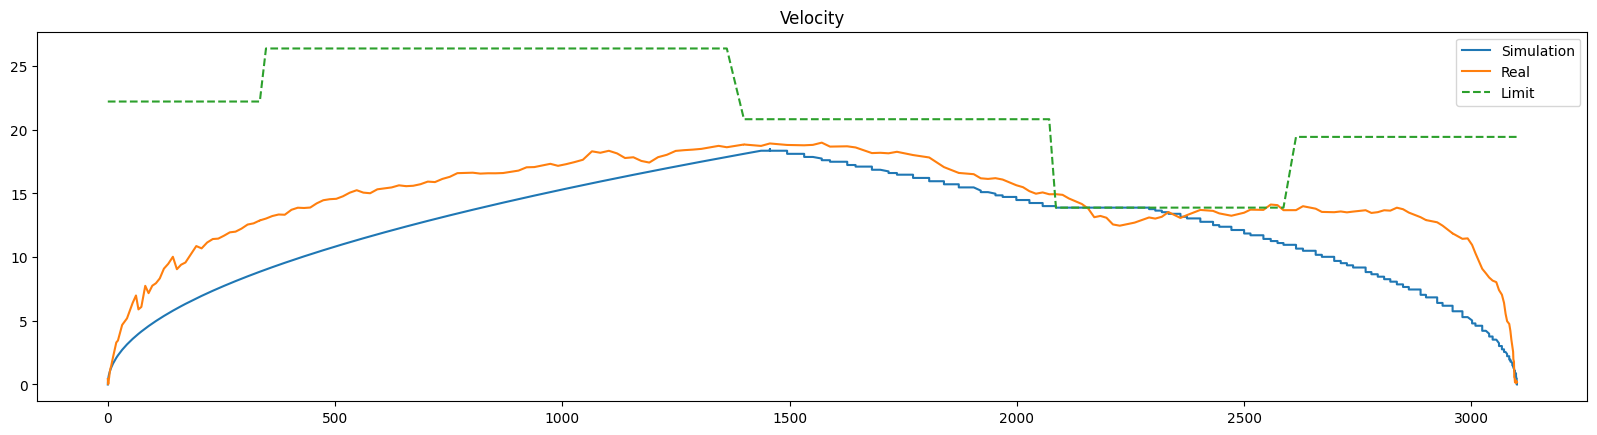

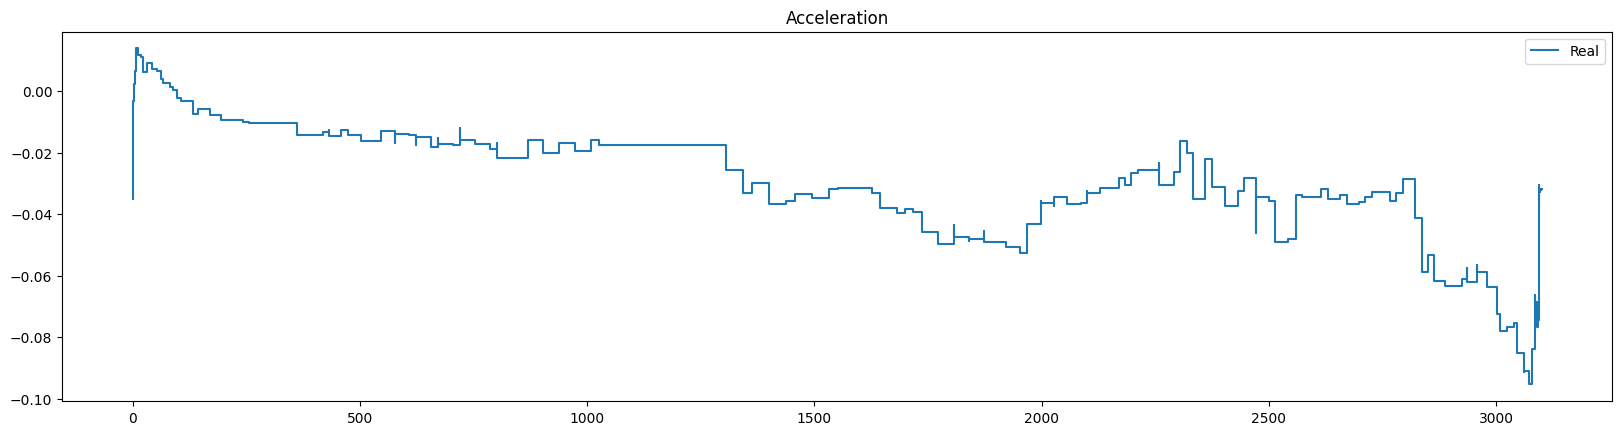

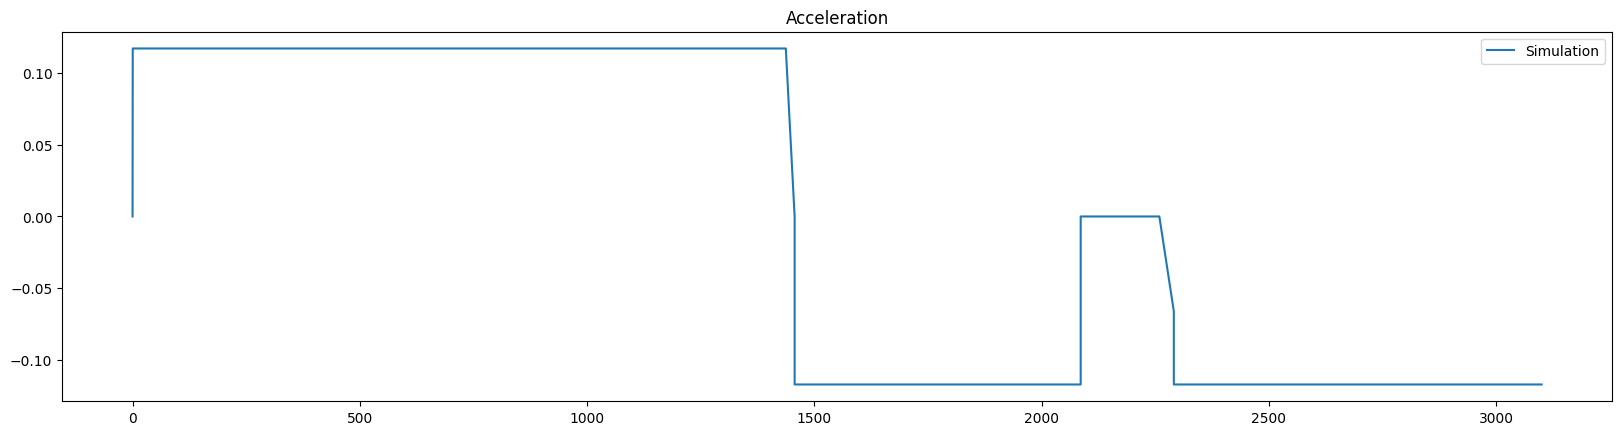

DTW: 146.1268661325431


In [12]:
importlib.reload(tconsumption)

compare_data(
    df_slice,
    "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson"
)

#### Krnov ➡️ Milotice n.Opavou

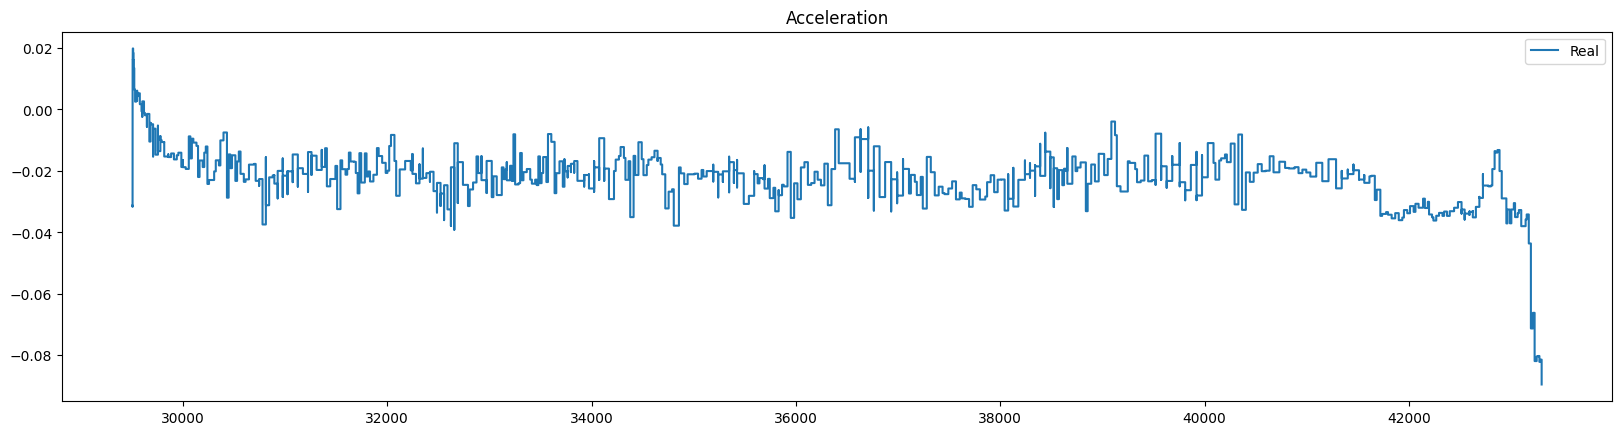

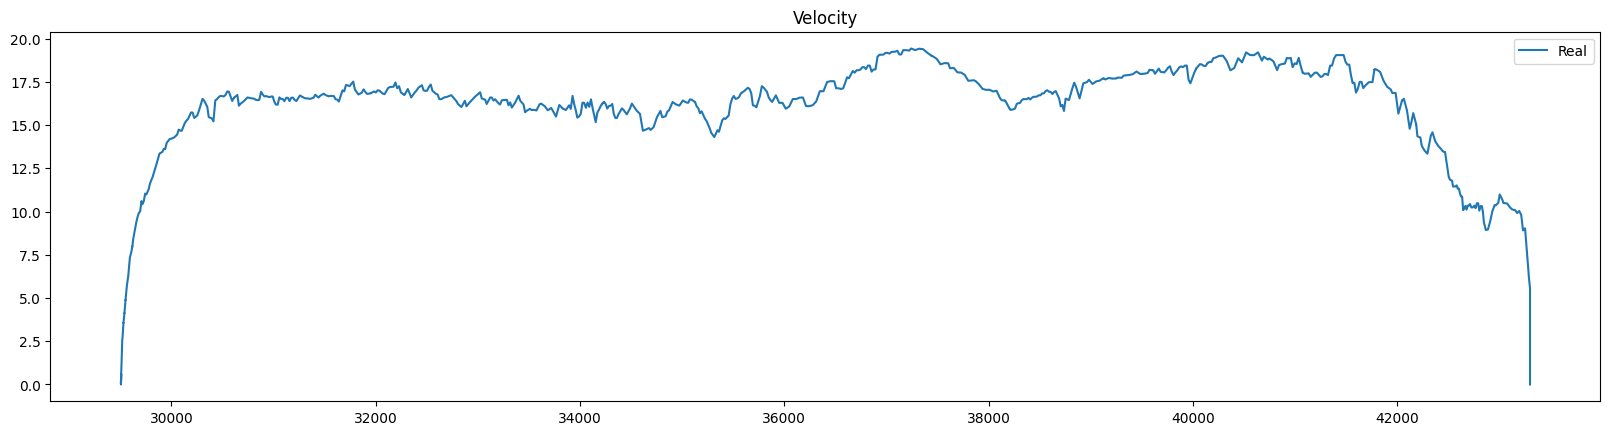

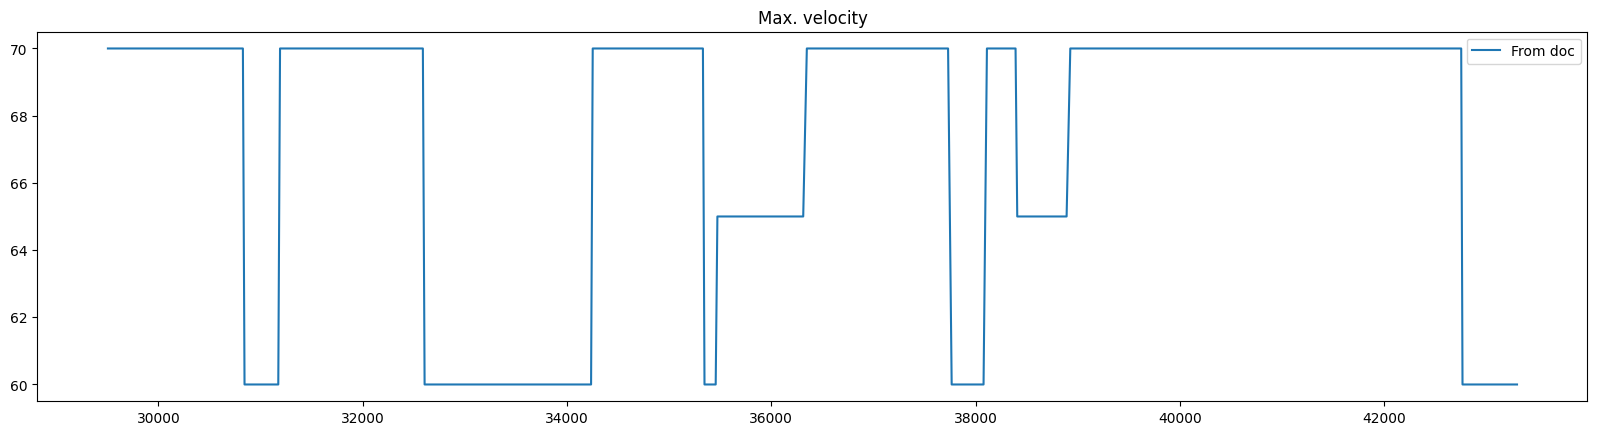

In [13]:
df_slice = df.loc[5570:7770] # Rozsah bodů mezi stanicemi

map_velocity(df_slice, 87.056, "../testing-data/velocity-data/310-pj.json")

render_plot("Acceleration", df_slice["cumulative_distance_m"], [df_slice["accel_proc_y"]], ["Real"])
render_plot("Velocity", df_slice["cumulative_distance_m"], [df_slice["gps_speed"]], ["Real"])
render_plot("Max. velocity", df_slice["cumulative_distance_m"], [df_slice["track_velocity"]], ["From doc"])

In [14]:
prep({
    # "input": "NOT NEEDED",
    "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-milotice.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
    "dbtable": "train_testing_data"
}, df=df_slice)

ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such fi

unique velocities in km/h {65.0, 60.00000000000001, 70.0}


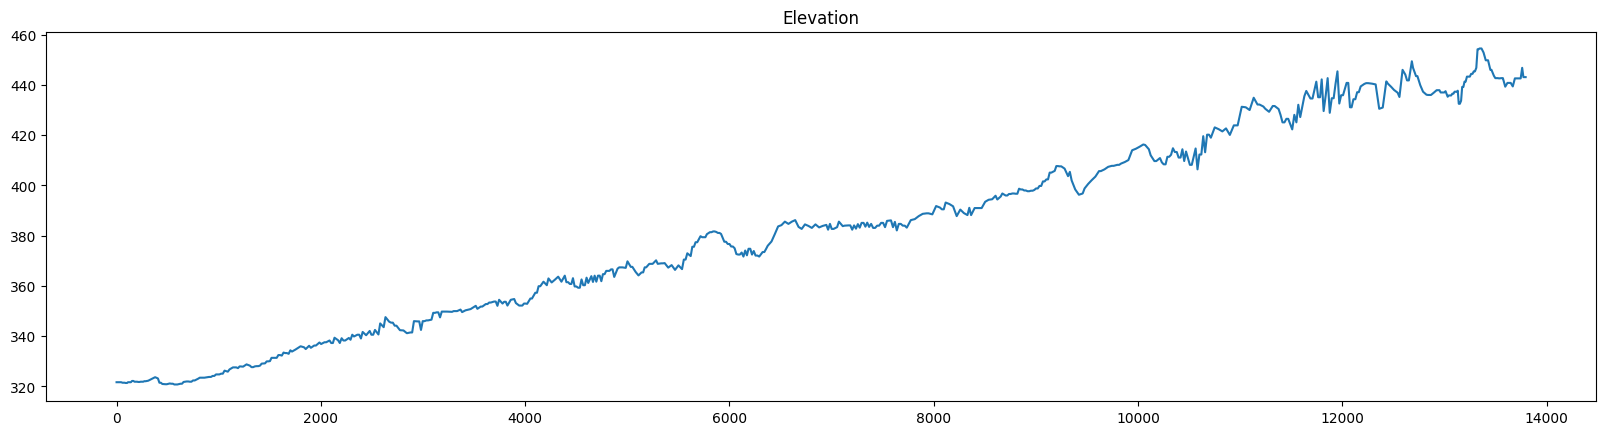

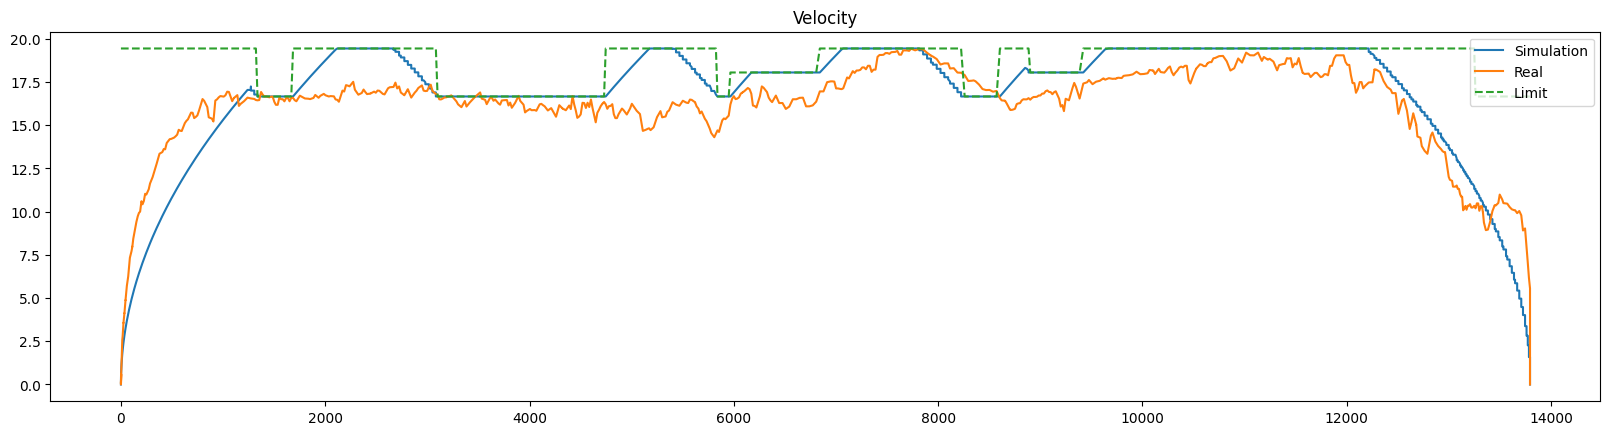

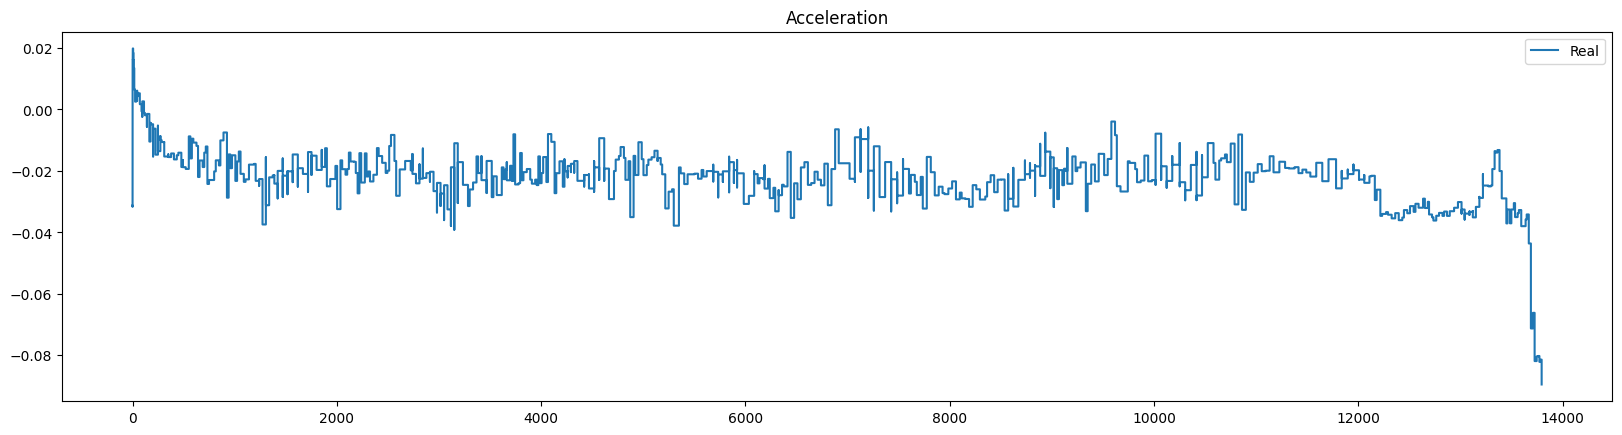

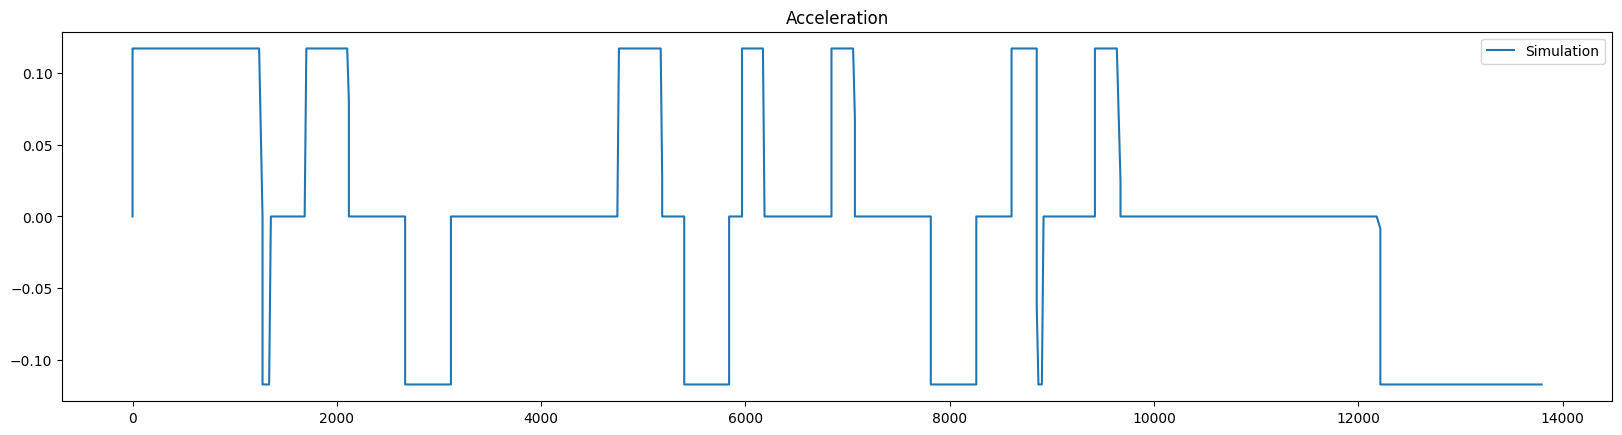

DTW: 1246.3334753241038


In [15]:
importlib.reload(tconsumption)

compare_data(
    df_slice,
    "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-milotice.geojson"
)

#### Milotice n.Opavou ➡️ Bruntál

In [16]:
# df_slice = df.loc[7770:9000] # Rozsah bodů mezi stanicemi

# map_velocity(df_slice, 73.260, "../testing-data/velocity-data/310-pj.json")

# render_plot("Acceleration", df_slice["cumulative_distance_m"], [df_slice["accel_proc_y"]], ["Real"])
# render_plot("Velocity", df_slice["cumulative_distance_m"], [df_slice["gps_speed"]], ["Real"])
# # render_plot("Max. velocity", df_slice["cumulative_distance_m"], [df_slice["track_velocity"]], ["From doc"])

In [17]:
# prep({
#     # "input": "NOT NEEDED",
#     "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_milotice-bruntal.geojson",
#     "host": "localhost",
#     "dbname": "railway_mapdb",
#     "dbuser": "postgres",
#     "dbpass": "mysecretpassword",
#     "dbtable": "train_testing_data"
# }, df=df_slice)

In [18]:
# importlib.reload(tconsumption)

# compare_data(
#     df_slice,
#     "../testing-data/um7/um7capture_2023-09-29_06-26-06_milotice-bruntal.geojson"
# )

### 📱 Data z telefonu

In [19]:
# Find two stations (ramp up and ramp down)
df_phone_loc = pd.read_csv("../testing-data/seidl-telefon/Location.csv", delimiter=",")[220:860]
df_phone_loc.reset_index(inplace=True, drop=True)
start_time = df_phone_loc["time"].iloc[0]
stop_time = df_phone_loc["time"].iloc[-1]

# Find acceleration in the same timeframe
# (sampling rate different - that's is why like this)
df_phone_acc = pd.read_csv("../testing-data/seidl-telefon/Accelerometer.csv", delimiter=",")
df_phone_acc = df_phone_acc[(df_phone_acc["time"] >= start_time) & (df_phone_acc["time"] <= stop_time)]
df_phone_acc.reset_index(inplace=True, drop=True)
df_phone_acc

,time,seconds_elapsed,z,y,x
0,1695978715934436000,202.310436,-0.022504,0.057136,0.004057
1,1695978715953393400,202.329393,0.001695,0.057180,0.008538
2,1695978715972351000,202.348351,0.003605,0.048180,-0.007852
3,1695978715991308300,202.367308,0.022114,0.032709,0.027355
4,1695978716010265900,202.386266,-0.015833,0.031453,-0.031993
...,...,...,...,...,...
33626,1695979352841621000,839.217621,0.028306,0.154919,0.006014
33627,1695979352860578300,839.236578,0.001878,0.145120,0.012852
33628,1695979352879535600,839.255536,0.018169,0.189503,-0.011000
33629,1695979352898493000,839.274493,0.015572,0.218727,-0.005773


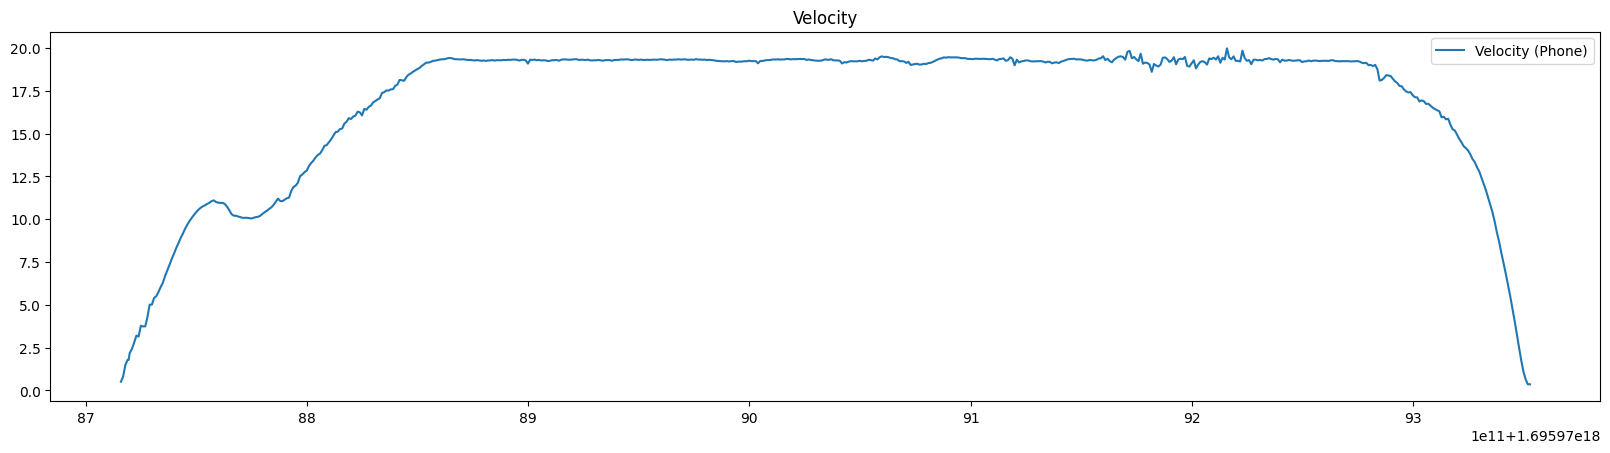

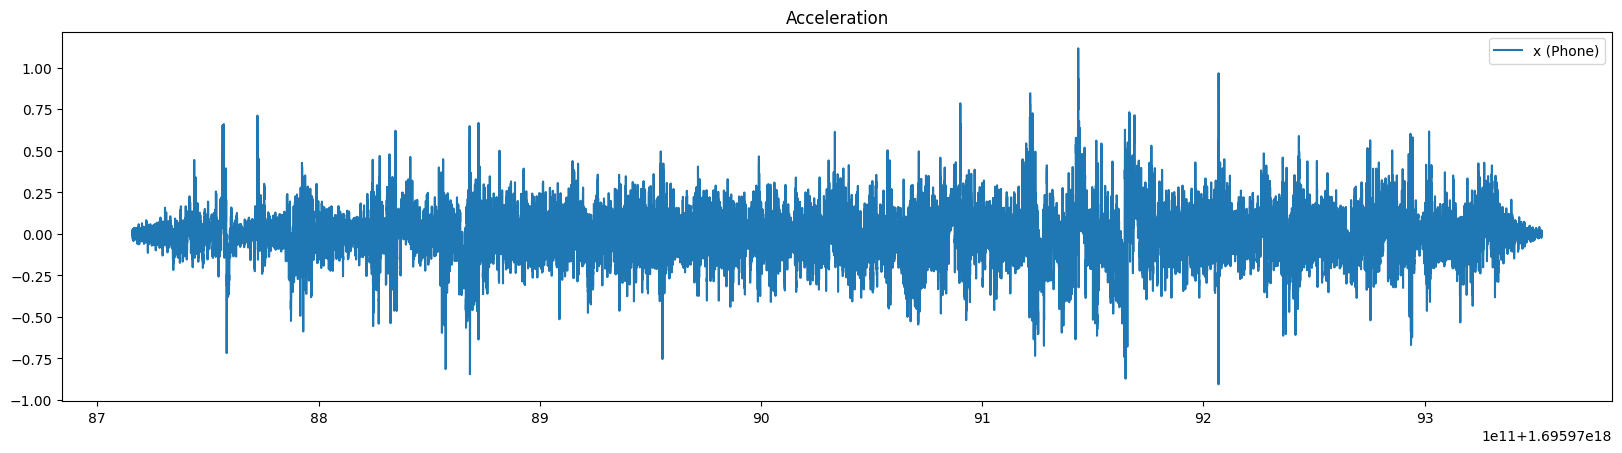

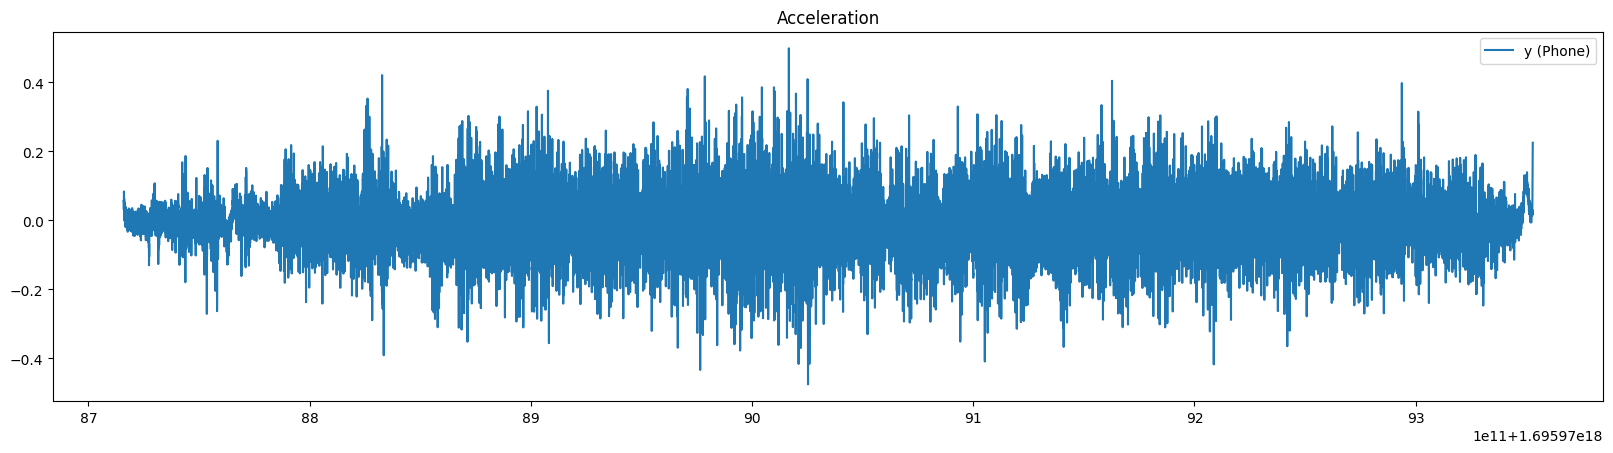

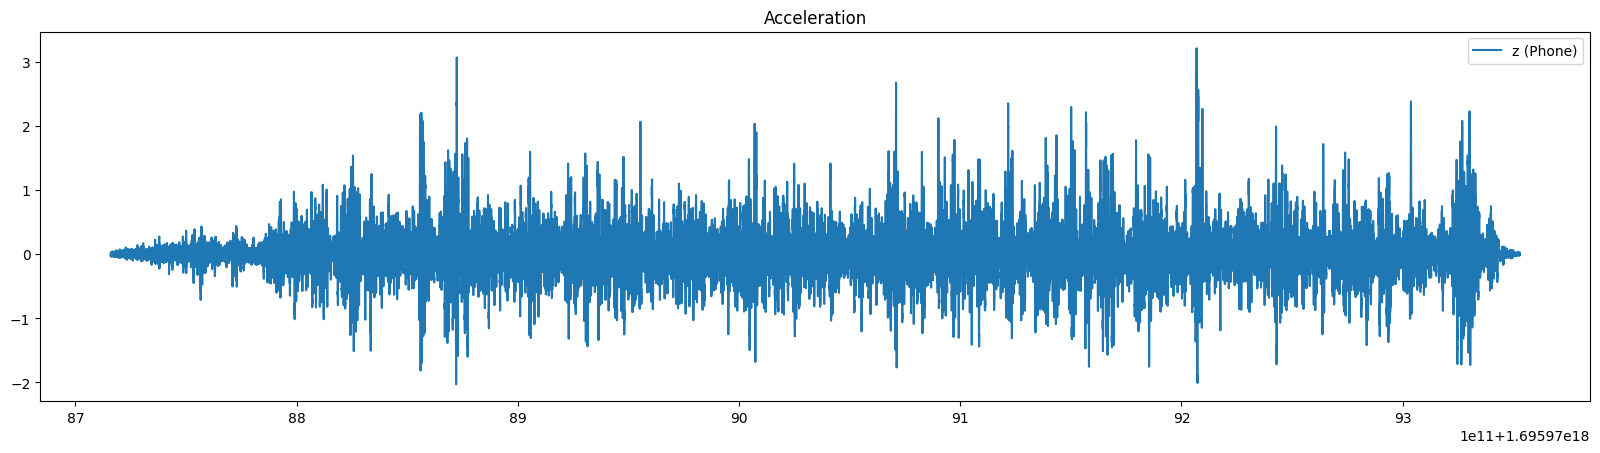

In [20]:
render_plot(
    "Velocity",
    df_phone_loc["time"],
    [df_phone_loc["speed"]],
    ["Velocity (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["x"]],
    ["x (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["y"]],
    ["y (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["z"]],
    ["z (Phone)"]
)

### 🇳🇴 Porovnání s norskou simulací

In [205]:
def map_velocity_2sim(points, first_offset, velocity_fp):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    dist_values = [0]
    for i,p in enumerate(points):
        if i+1 >= len(points):
            continue
        dist = tconsumption.calc_distance_two_points(p, points[i+1])
        dist_values.append(dist+dist_values[-1])

    max_velocities = []

    for d in dist_values:
        for tv in track_velocity[::-1]:
            start_in_m = tv["start"]*1000
            if first_offset*1000 - d < start_in_m:
                max_velocities.append(tv["value"])
                break

    return [x/3.6 for x in max_velocities]

def compare_data_2sim(df_sim, geojson_path: str, first_dist_offset, velocity_fp):
    # Calculated data
    c = tconsumption.Consumption()
    c.load_from_file(geojson_path)
    c.variable_params = {
        "Elevation smoothing": 100,
        "Curve smoothing": 10,
        "Curve A": 999,
        "Curve B": 100,
        "Running a": 2,
        "Running b": 0.054,
        "Running c": 0.00034,
        "Recuperation coefficient": 0.70,
        "Comfortable acceleration": 0.98
    }
    c.max_velocities_in_mps = map_velocity_2sim(c.points, first_dist_offset, velocity_fp)

    # Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
    c.params["power_limit"] = 480*1000
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 0

    # Running the simulation
    c.run()

    # Plotting
    render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
    render_plot(
        "Energy",
        c.series["dist_values"],
        [energy_calculated],
        ["JN simulation", "Norwegian simulation"],
        ["solid", "solid"]
    )

    render_plot(
        "Norwegian energy",
        df_sim["distance"],
        [df_sim["Battery"]],
        ["Battery"],
        ["solid"]
    )

    # render_plot(
    #     "Norwegian energy",
    #     df_sim["distance"],
    #     [df_sim["Battery"], df_sim["Hydrogen"], df_sim["Diesel"], df_sim["OLE"]],
    #     ["Battery", "Hydrogen", "Diesel", "OLE"],
    #     ["solid"]*4
    # )

    render_plot(
        "Exerted force",
        c.series["dist_values"],
        [c.series["exerted_force_values"]],
        ["JN simulation"],
        ["solid", "solid"]
    )

    render_plot(
        "Velocity",
        c.series["dist_values"],
        [c.series["velocity_values"], c.max_velocities_in_mps+[c.max_velocities_in_mps[-1]]],
        ["JN simulation", "Max velocity"],
        ["solid", "dashed"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [c.series["acceleration_values"]],
        ["JN simulation"],
        ["solid"]
    )

    print(f"JN simulation final energy: {energy_calculated[-1]}")
    print(f"Norwegian simulation final energy: {df_sim['Battery'].iloc[-1]}")

    dtw = fastdtw(energy_calculated, df_sim["Battery"])[0]
    print("DTW:", dtw)

In [188]:
get_rail({
    "output": "../testing-data/norway-sim/opava-olomouc.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
}, 49002, True)

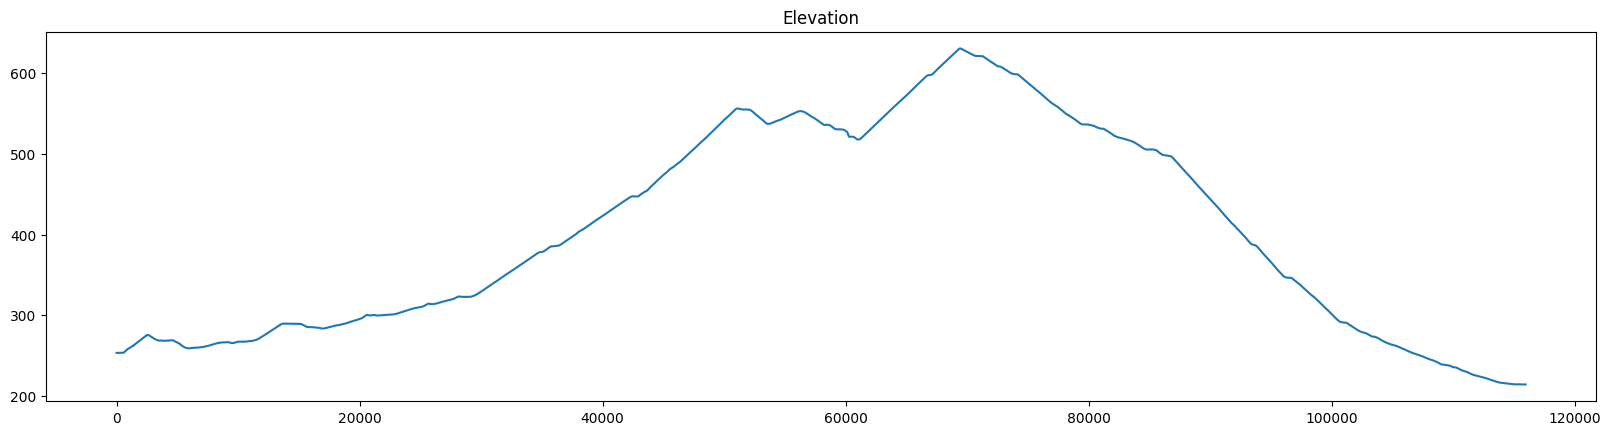

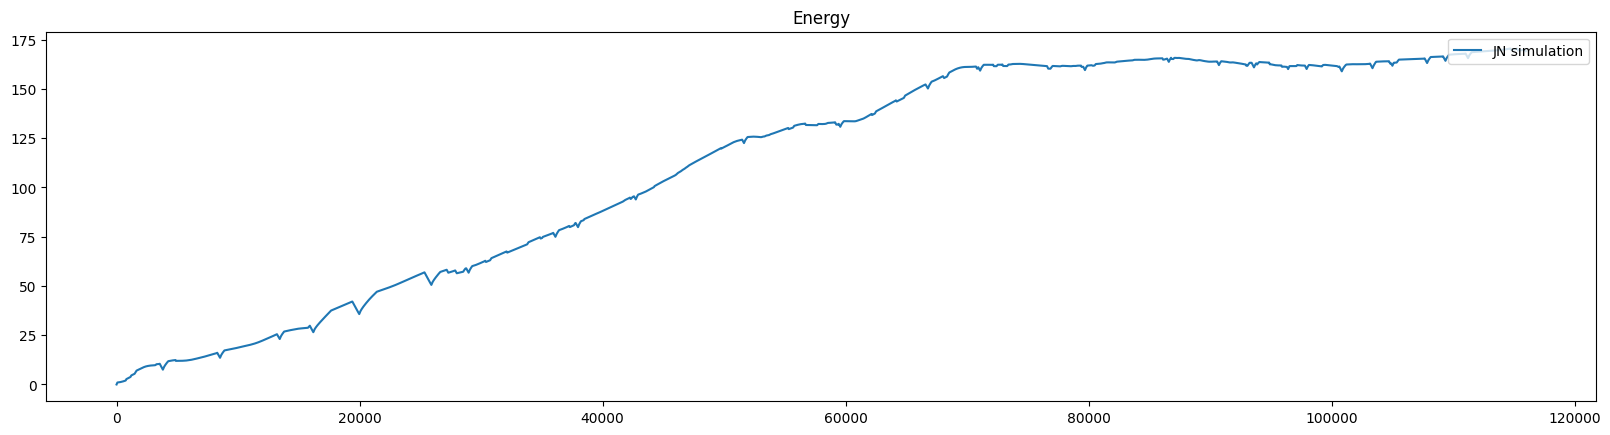

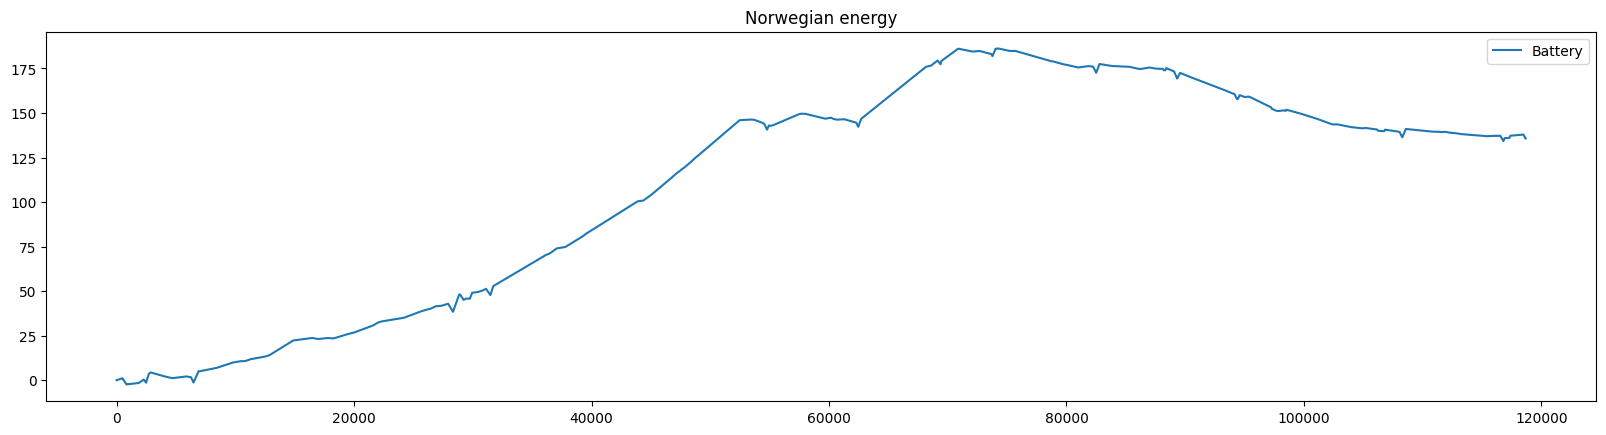

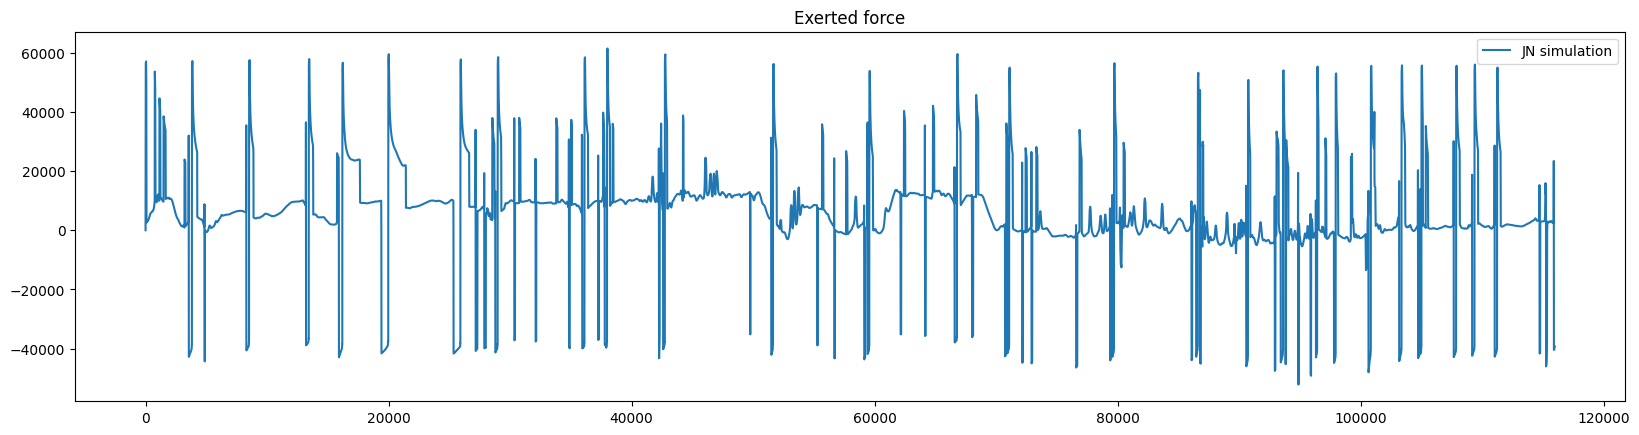

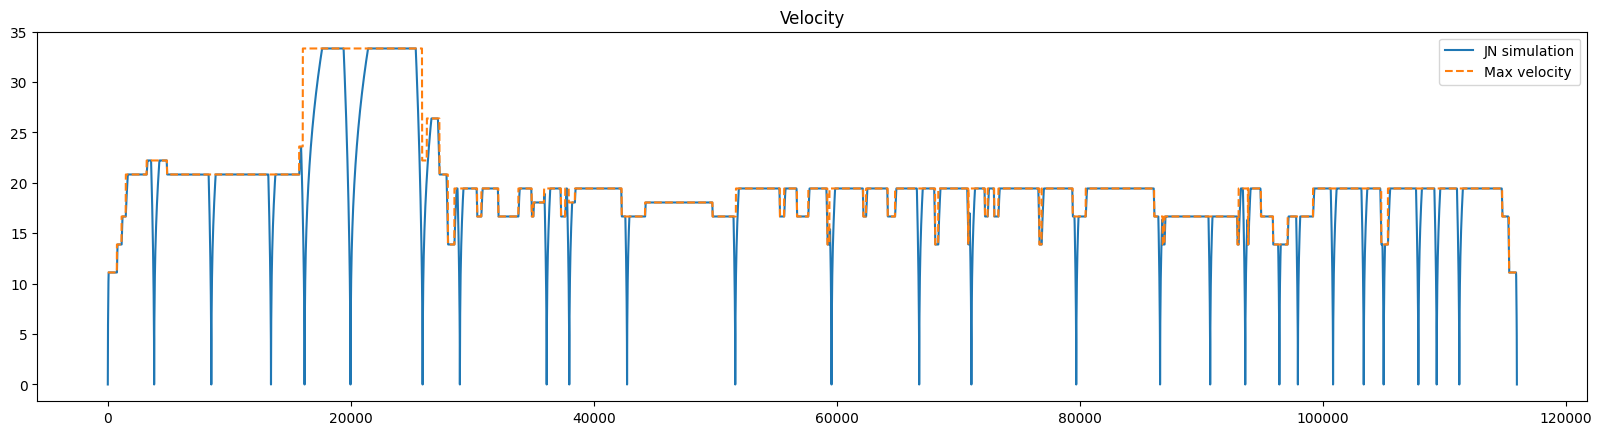

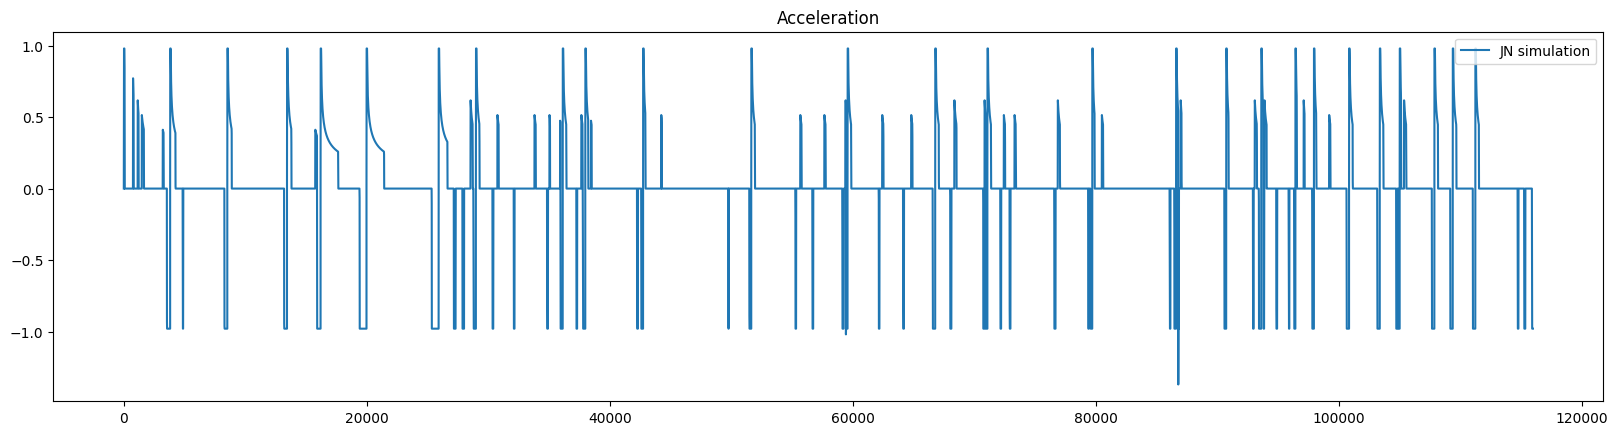

JN simulation final energy: 169.17171342917666
Norwegian simulation final energy: 135.61772263885865
DTW: 86318.5595144524


In [206]:
# Read and process
df_norway = pd.read_csv("../testing-data/norway-sim/West_energy.csv", delimiter=",", header=[0,1])
df_norway.columns = [x[0] for x in df_norway.columns]
df_norway = df_norway.rename(columns={"Unnamed: 0_level_0": "distance"})

# Remove first few stations (Ostrava-Opava)
df_norway = df_norway[df_norway["distance"] >= 36000]
df_norway.reset_index(inplace=True, drop=True)

# Reset variables
for k in df_norway.keys():
    offset_value = df_norway[k].iloc[0]
    df_norway[k] = df_norway[k] - offset_value

compare_data_2sim(
    df_norway,
    "../testing-data/norway-sim/opava-olomouc.geojson",
    116.193, "../testing-data/velocity-data/310.json"
)

### 🚧 Ladění algoritmu

[0, 410, 849, 1398, 1688, 2030, 2597, 2935, 3713, 3903, 4398, 5363, 6100, 6730, 7120, 7968, 8656, 9047, 9337, 9602, 9772, 10045, 10261, 10414, 10726, 10907, 11123, 11641]


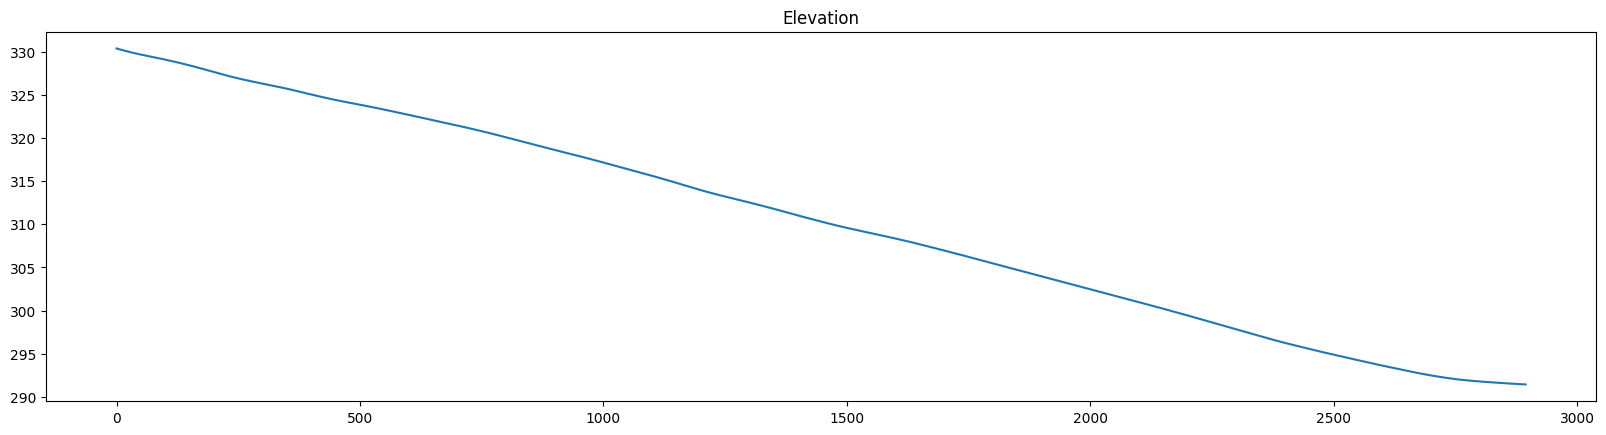

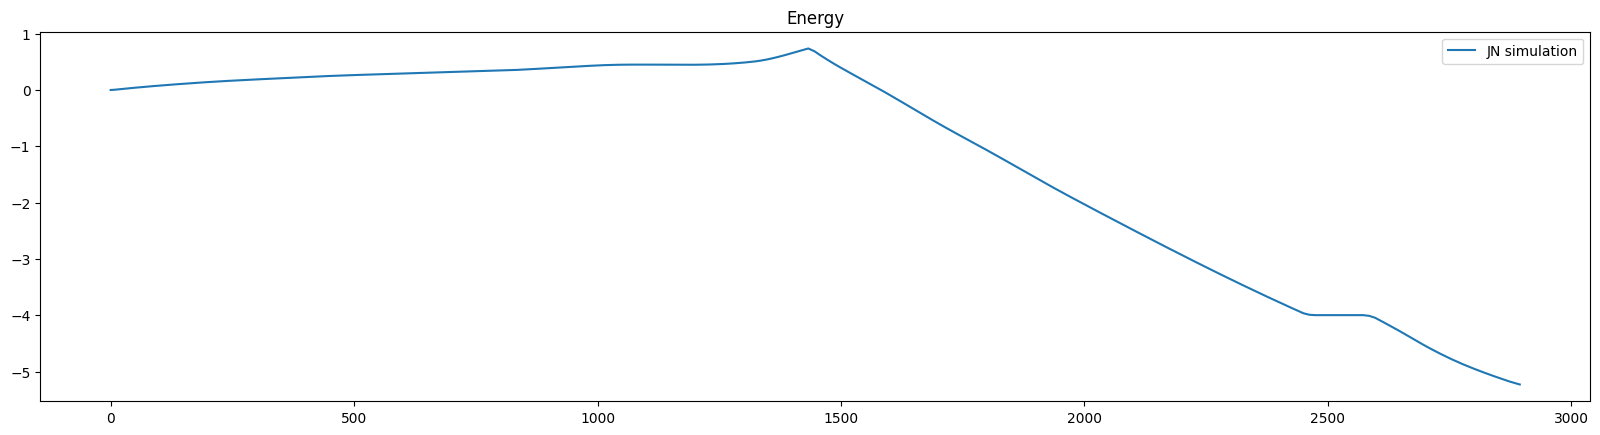

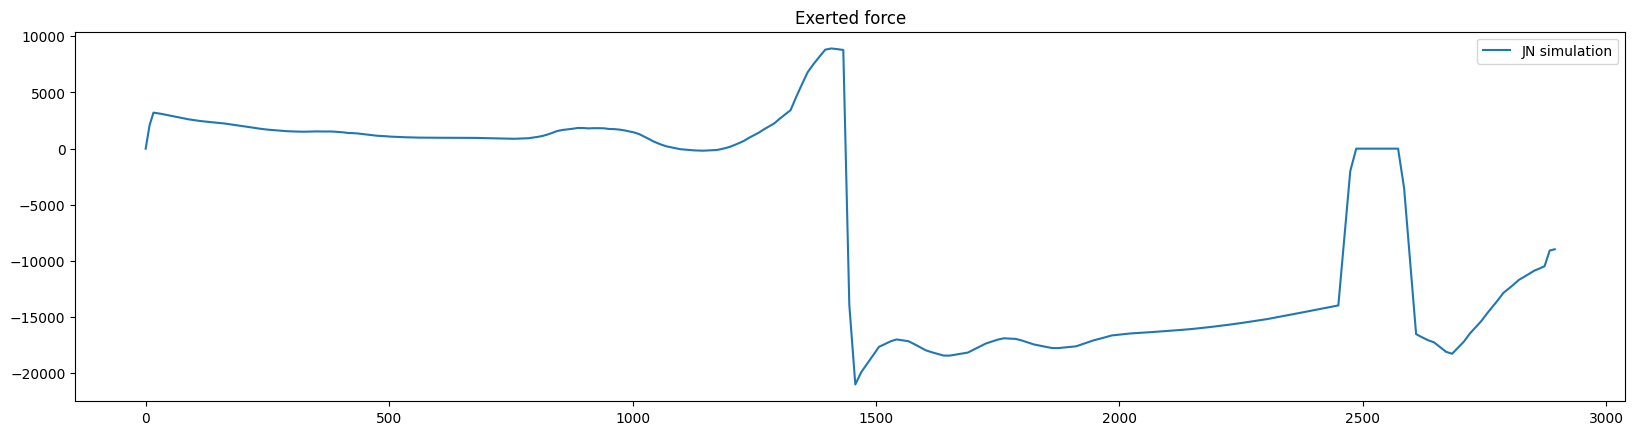

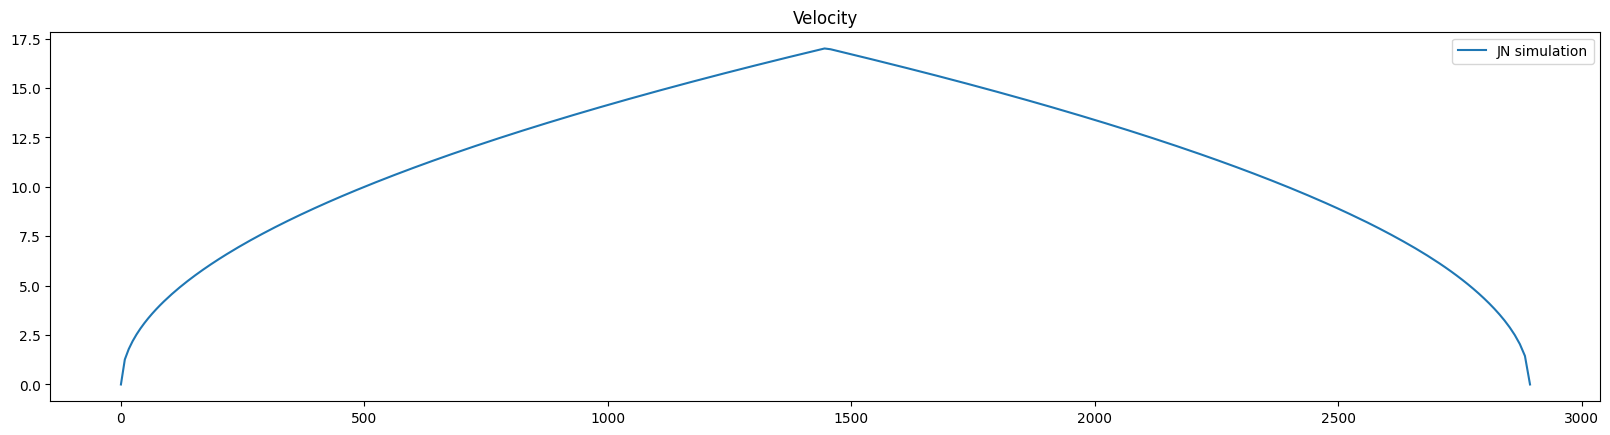

JN simulation final energy: -5.228312799488363


In [102]:
importlib.reload(tconsumption)

# Calculated data
c = tconsumption.Consumption()
c.variable_params = {
    "Elevation smoothing": 100,
    "Curve smoothing": 10,
    "Curve A": 999,
    "Curve B": 100,
    "Running a": 2,
    "Running b": 0.054,
    "Running c": 0.00034,
    "Recuperation coefficient": 1,
    "Comfortable acceleration": 0.1
}
c.load_from_file("../testing-data/norway-sim/opava-olomouc.geojson")
# c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"]) # TODO: Add limits

# Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
c.params["power_limit"] = 480*1000
c.params["mass_locomotive"] = 56000
c.params["mass_wagon"] = 0

# Picking a slice
print(c.stations)
from_station = 20
to_station = 21

start_idx = c.stations[from_station]
end_idx = c.stations[to_station]

c.points = c.points[start_idx:end_idx]
c.stations = c.stations[from_station:to_station+1]
c.stations = [x-c.stations[0] for x in c.stations]
c.max_velocities_in_mps = c.max_velocities_in_mps[start_idx:end_idx]
c.series["elevation_values"] = c.series["elevation_values"][start_idx:end_idx]

# Running the simulation
c.run()

# Plotting
render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
render_plot(
    "Energy",
    c.series["dist_values"],
    [energy_calculated],
    ["JN simulation"],
    ["solid"]
)
render_plot(
    "Exerted force",
    c.series["dist_values"],
    [c.series["exerted_force_values"]],
    ["JN simulation"],
    ["solid", "solid"]
)

render_plot(
    "Velocity",
    c.series["dist_values"],
    [c.series["velocity_values"]],
    ["JN simulation", "Norwegian simulation"],
    ["solid", "solid"]
)

print(f"JN simulation final energy: {energy_calculated[-1]}")

# dtw = fastdtw(energy_calculated, HERE)[0]
# print("DTW:", dtw)